In [98]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import numpy as np
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
from matplotlib.gridspec import GridSpec
import os

In [101]:
current_working_directory = os.getcwd()
lab_directory = os.path.dirname(current_working_directory)
paper_dir = os.path.join(lab_directory, "paper")
folder_figures = os.path.join(paper_dir, "plots")
folder_tables = os.path.join(paper_dir, "tabelas")

columns_Y = [
    "UpwardUsedSecondaryReserveEnergy",
    "DownwardUsedSecondaryReserveEnergy",
]

data_folder = os.path.join(lab_directory, "data")
training_dataset_path = os.path.join(
    data_folder, "processed", "dados_2014-2022.csv"
)

training_dataset = pd.read_csv(training_dataset_path, index_col=0)

training_dataset["datetime"] = pd.to_datetime(training_dataset["datetime"])

In [102]:
years_to_use = [2019, 2020, 2021, 2022]
validation_dataset = training_dataset[
    training_dataset["datetime"].dt.year.isin(years_to_use)
]

In [103]:
pairs_dict = {
    "Upward Allocation": {
        "test": "UpwardUsedSecondaryReserveEnergy",
        "benchmark": "SecondaryReserveAllocationAUpward",
    },
    "Downward Allocation": {
        "test": "DownwardUsedSecondaryReserveEnergy",
        "benchmark": "SecondaryReserveAllocationADownward",
    },
}

In [104]:
trans_dict = {
    "Upward Allocation": "Alocação para cima",
    "Downward Allocation": "Alocação para baixo",
}

In [107]:
dataset = validation_dataset
dataset.set_index("datetime", inplace=True)

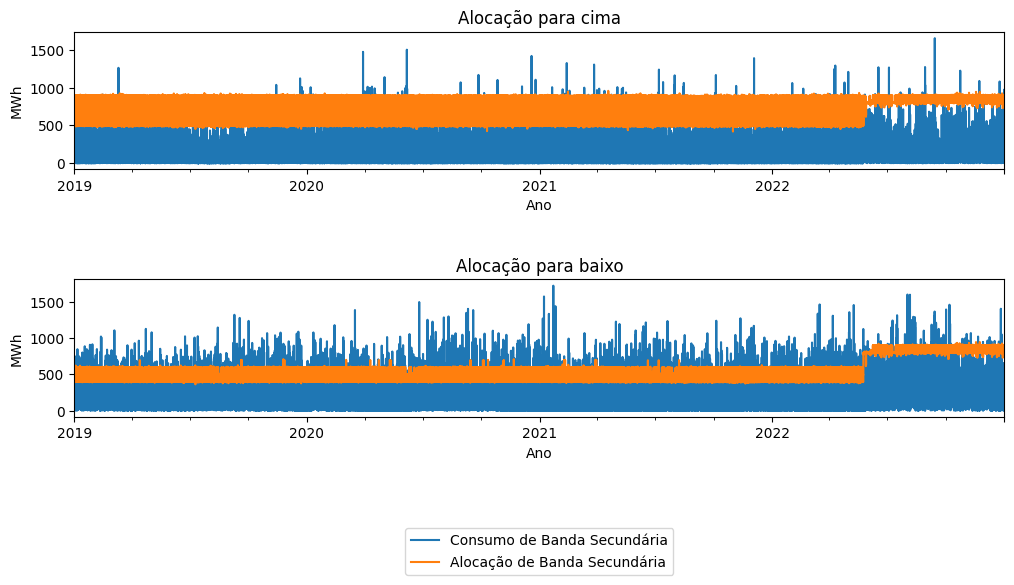

In [117]:
nrows = 2
ncols = 1

count = 0
fig, axis = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 5))

for alloc, col_names in pairs_dict.items():
    test_col = col_names["test"]
    benchmark_col = col_names["benchmark"]

    # Adjust the vertical spacing here
    plt.subplots_adjust(hspace=0.8)
    ax = axis.flatten()[count]

    # Check target distribution
    dataset[test_col].plot(ax=ax, label="Consumo de Banda Secundária")
    dataset[benchmark_col].plot(ax=ax, label="Alocação de Banda Secundária")
    alloc_trans = trans_dict[alloc]

    ax.set_title(alloc_trans)
    # ax.xaxis.set_major_locator(mdates.YearLocator())
    # ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    # Set x-axis label to "Ano"
    ax.set_xlabel("Ano")
    # Set y-axis label to "MWh"
    ax.set_ylabel("MWh")

    count += 1

plt.legend(bbox_to_anchor=(0.5, -1.2), loc="lower center")

# plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()
fig.savefig(
    os.path.join(folder_figures, "benchmark_alocacoes_validacao.png"),
    bbox_inches="tight",
)

In [119]:
dataset_plot = dataset

In [ ]:
dataset_plot["erro_up_benchmark"] = (
    dataset_plot["UpwardUsedSecondaryReserveEnergy"]
    - dataset_plot["SecondaryReserveAllocationAUpward"]
)
dataset_plot["erro_down_benchmark"] = (
    dataset_plot["DownwardUsedSecondaryReserveEnergy"]
    - dataset_plot["SecondaryReserveAllocationADownward"]
)
dataset_plot["erro_up_benchmark_abs"] = dataset_plot["erro_up_benchmark"].abs()
dataset_plot["erro_down_benchmark_abs"] = dataset_plot[
    "erro_down_benchmark"
].abs()


dataset_plot["DownBenchmarkAllocF"] = 0.0
dataset_plot["DownBenchmarkAllocD"] = 0.0


dataset_plot["UpBenchmarkAllocF"] = 0.0
dataset_plot["UpBenchmarkAllocD"] = 0.0


mising_mask_benchmark_up = dataset_plot["erro_up_benchmark"] > 0
surplus_mask_benchmark_up = dataset_plot["erro_up_benchmark"] < 0


mising_mask_benchmark_down = dataset_plot["erro_down_benchmark"] > 0
surplus_mask_benchmark_down = dataset_plot["erro_down_benchmark"] < 0


dataset_plot.loc[mising_mask_benchmark_down, "DownBenchmarkAllocF"] = (
    dataset_plot.loc[mising_mask_benchmark_down, "erro_down_benchmark_abs"]
)
dataset_plot.loc[surplus_mask_benchmark_down, "DownBenchmarkAllocD"] = (
    dataset_plot.loc[surplus_mask_benchmark_down, "erro_down_benchmark_abs"]
)
dataset_plot.loc[mising_mask_benchmark_up, "UpBenchmarkAllocF"] = (
    dataset_plot.loc[mising_mask_benchmark_up, "erro_up_benchmark_abs"]
)
dataset_plot.loc[surplus_mask_benchmark_up, "UpBenchmarkAllocD"] = (
    dataset_plot.loc[surplus_mask_benchmark_up, "erro_up_benchmark_abs"]
)


dataset_plot["erro_up_benchmark_per"] = (
    dataset_plot["erro_up_benchmark"]
    / dataset_plot["UpwardUsedSecondaryReserveEnergy"]
) * 100
dataset_plot["erro_down_benchmark_per"] = (
    dataset_plot["erro_down_benchmark"]
    / dataset_plot["DownwardUsedSecondaryReserveEnergy"]
) * 100

upzeromask = dataset_plot["UpwardUsedSecondaryReserveEnergy"] == 0
downzeromask = dataset_plot["DownwardUsedSecondaryReserveEnergy"] == 0


dataset_plot.loc[upzeromask, "erro_up_benchmark_per"] = (
    (dataset_plot.loc[upzeromask, "erro_up_benchmark"] + 1)
    / (dataset_plot.loc[upzeromask, "UpwardUsedSecondaryReserveEnergy"] + 1)
) * 100

dataset_plot.loc[downzeromask, "erro_down_benchmark_per"] = (
    (dataset_plot.loc[downzeromask, "erro_down_benchmark"] + 1)
    / (
        dataset_plot.loc[downzeromask, "DownwardUsedSecondaryReserveEnergy"]
        + 1
    )
) * 100

In [123]:
def get_best_period_on_dataframe(df, metric, biggest=False, period="1ME"):
    sampling_means = df.resample(period)[metric].mean()
    if biggest:
        opt_index_end = sampling_means.idxmax()
    else:
        opt_index_end = sampling_means.idxmin()

    opt_index_start = sampling_means[:opt_index_end].iloc[-2:].index[0]
    return opt_index_start, opt_index_end

In [124]:
benchmark_down_best_month = get_best_period_on_dataframe(
    dataset_plot, "erro_down_benchmark_abs", biggest=False, period="1ME"
)
benchmark_down_best_week = get_best_period_on_dataframe(
    dataset_plot, "erro_down_benchmark_abs", biggest=False, period="1W"
)
benchmark_down_best_day = get_best_period_on_dataframe(
    dataset_plot, "erro_down_benchmark_abs", biggest=False, period="1D"
)

benchmark_down_worst_month = get_best_period_on_dataframe(
    dataset_plot, "erro_down_benchmark_abs", biggest=True, period="1ME"
)
benchmark_down_worst_week = get_best_period_on_dataframe(
    dataset_plot, "erro_down_benchmark_abs", biggest=True, period="1W"
)
benchmark_down_worst_day = get_best_period_on_dataframe(
    dataset_plot, "erro_down_benchmark_abs", biggest=True, period="1D"
)


benchmark_up_best_month = get_best_period_on_dataframe(
    dataset_plot, "erro_up_benchmark_abs", biggest=False, period="1ME"
)
benchmark_up_best_week = get_best_period_on_dataframe(
    dataset_plot, "erro_up_benchmark_abs", biggest=False, period="1W"
)
benchmark_up_best_day = get_best_period_on_dataframe(
    dataset_plot, "erro_up_benchmark_abs", biggest=False, period="1D"
)

benchmark_up_worst_month = get_best_period_on_dataframe(
    dataset_plot, "erro_up_benchmark_abs", biggest=True, period="1ME"
)
benchmark_up_worst_week = get_best_period_on_dataframe(
    dataset_plot, "erro_up_benchmark_abs", biggest=True, period="1W"
)
benchmark_up_worst_day = get_best_period_on_dataframe(
    dataset_plot, "erro_up_benchmark_abs", biggest=True, period="1D"
)


benchmark_couples_down = [
    [benchmark_down_best_month, benchmark_down_worst_month],
    [benchmark_down_best_week, benchmark_down_worst_week],
    [benchmark_down_best_day, benchmark_down_worst_day],
]
benchmark_couples_up = [
    [benchmark_up_best_month, benchmark_up_worst_month],
    [benchmark_up_best_week, benchmark_up_worst_week],
    [benchmark_up_best_day, benchmark_up_worst_day],
]

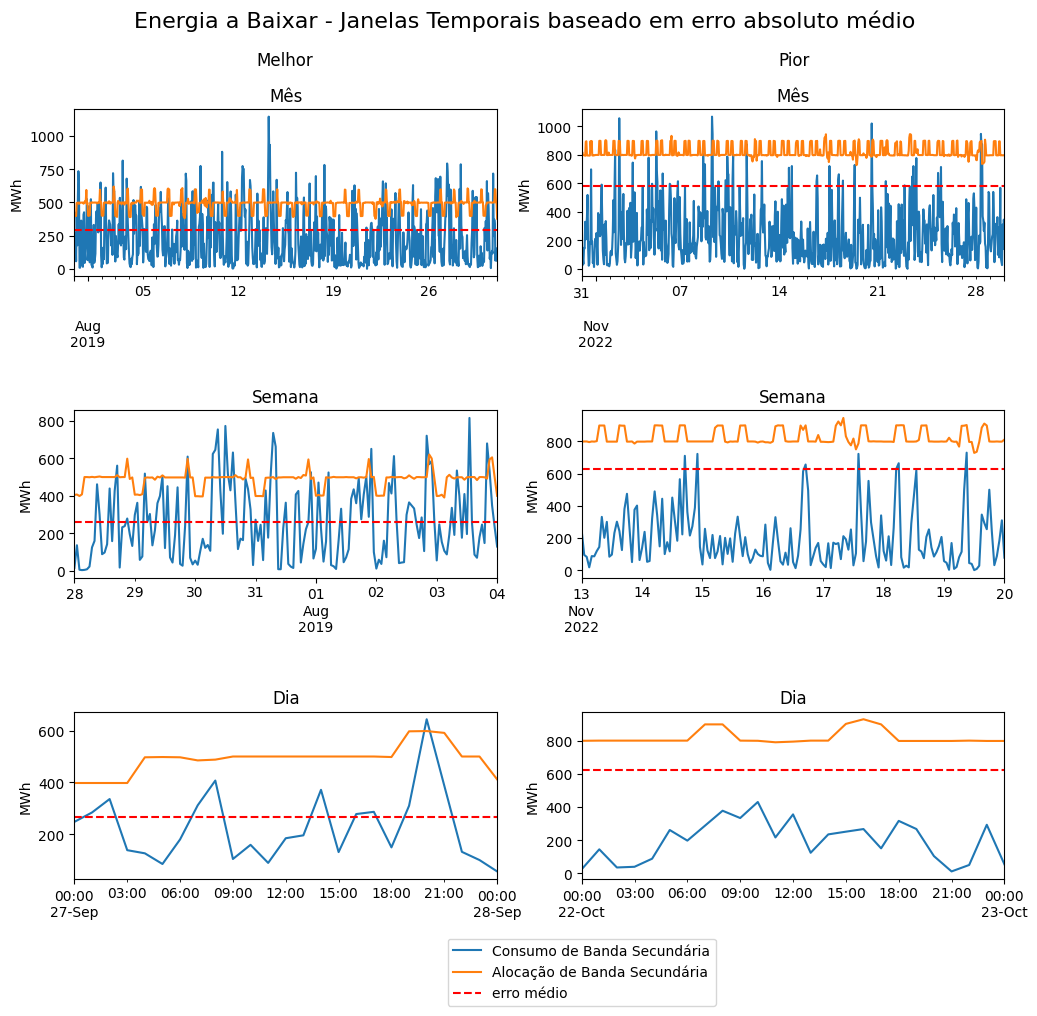

In [125]:
couples_list = benchmark_couples_down
truth_metric = "DownwardUsedSecondaryReserveEnergy"
benchmark_metric = "SecondaryReserveAllocationADownward"
error_metric_benchmark = "erro_down_benchmark_abs"

time_periods = ["Mês", "Semana", "Dia"]
column_titles = ["Melhor", "Pior"]  # Customize these titles as needed
nrows = 3
ncols = 2
fig, axis = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 10))

for r, time_per in enumerate(couples_list):
    for c, tf in enumerate(time_per):
        start, end = tf
        ax = axis[r, c]
        dataset_plot_time_range = dataset_plot[start:end]
        dataset_plot_time_range[truth_metric].plot(
            ax=axis[r, c], label="Consumo de Banda Secundária"
        )
        dataset_plot_time_range[benchmark_metric].plot(
            ax=axis[r, c], label="Alocação de Banda Secundária"
        )
        ax.axhline(
            y=dataset_plot_time_range[error_metric_benchmark].mean(),
            color="red",
            linestyle="--",
            label="erro médio",
        )
        plt.subplots_adjust(hspace=0.8)
        ax.set_ylabel("MWh")
        ax.set_xlabel("")
        ax.set_title(time_periods[r])
plt.legend(bbox_to_anchor=(0.0, -0.8), loc="lower center")
fig.suptitle(
    "Energia a Baixar - Janelas Temporais baseado em erro absoluto médio",
    fontsize=16,
)
# fig.text(0.5, 0.92, 'Baseado em erro absoluto médio', ha='center', va='bottom', fontsize=12)
# plt.suptitle("Your Chart's Title")
# plt.title("Your Chart's Subtitle")
# plt.suptitle("Your Chart's Title")

for c in range(ncols):
    fig.text(
        0.30 + (c * 0.425),
        0.92,
        column_titles[c],
        ha="center",
        va="bottom",
        fontsize=12,
    )


# plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()
fig.savefig(
    os.path.join(folder_figures, "alocacoes_temporais_downward_dataset.png"),
    bbox_inches="tight",
)

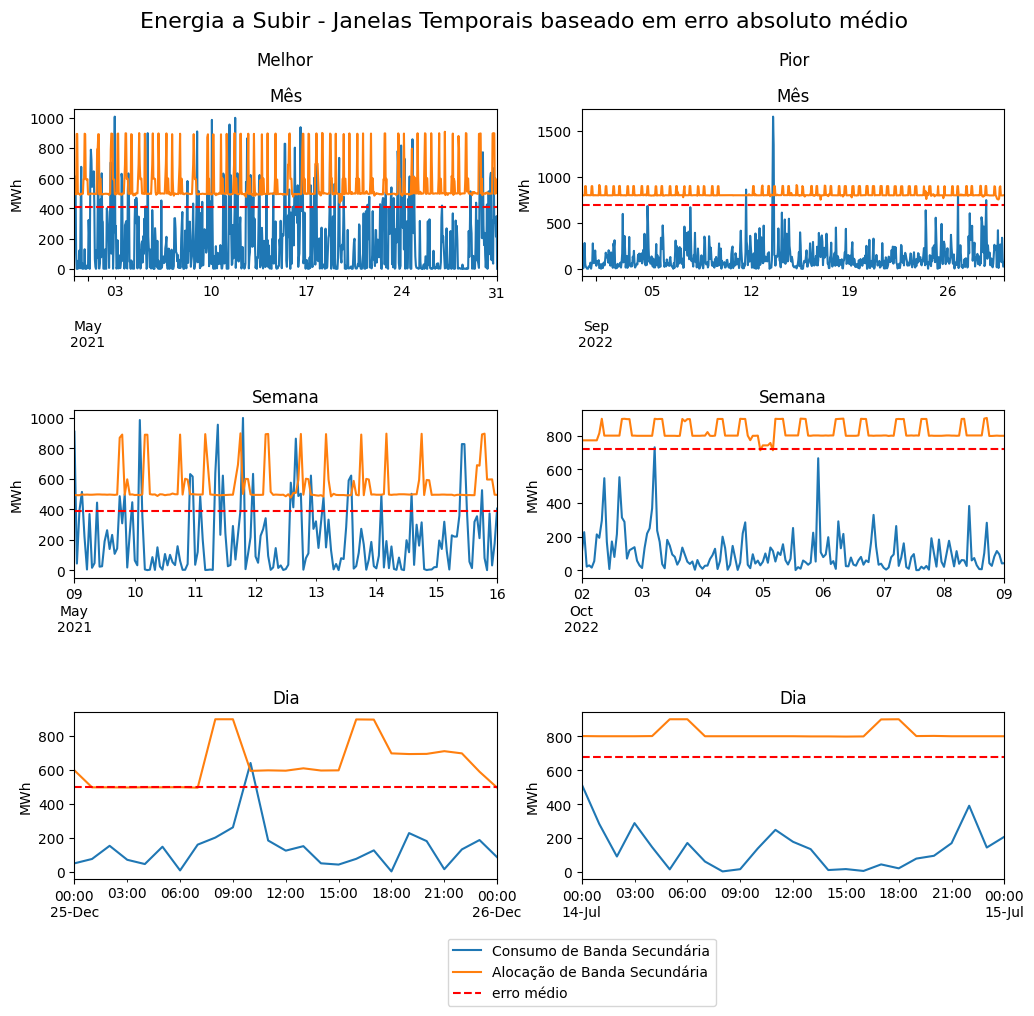

In [126]:
couples_list = benchmark_couples_up
truth_metric = "UpwardUsedSecondaryReserveEnergy"
benchmark_metric = "SecondaryReserveAllocationAUpward"
error_metric_benchmark = "erro_up_benchmark_abs"

time_periods = ["Mês", "Semana", "Dia"]
column_titles = ["Melhor", "Pior"]  # Customize these titles as needed
nrows = 3
ncols = 2
fig, axis = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 10))

for r, time_per in enumerate(couples_list):
    for c, tf in enumerate(time_per):
        start, end = tf
        ax = axis[r, c]
        dataset_plot_time_range = dataset_plot[start:end]
        dataset_plot_time_range[truth_metric].plot(
            ax=axis[r, c], label="Consumo de Banda Secundária"
        )
        dataset_plot_time_range[benchmark_metric].plot(
            ax=axis[r, c], label="Alocação de Banda Secundária"
        )
        ax.axhline(
            y=dataset_plot_time_range[error_metric_benchmark].mean(),
            color="red",
            linestyle="--",
            label="erro médio",
        )
        plt.subplots_adjust(hspace=0.8)
        ax.set_ylabel("MWh")
        ax.set_xlabel("")
        ax.set_title(time_periods[r])
plt.legend(bbox_to_anchor=(0.0, -0.8), loc="lower center")
fig.suptitle(
    "Energia a Subir - Janelas Temporais baseado em erro absoluto médio",
    fontsize=16,
)
# fig.text(0.5, 0.92, 'Baseado em erro absoluto médio', ha='center', va='bottom', fontsize=12)
# plt.suptitle("Your Chart's Title")
# plt.title("Your Chart's Subtitle")
# plt.suptitle("Your Chart's Title")

for c in range(ncols):
    fig.text(
        0.30 + (c * 0.425),
        0.92,
        column_titles[c],
        ha="center",
        va="bottom",
        fontsize=12,
    )


# plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()
fig.savefig(
    os.path.join(folder_figures, "alocacoes_temporais_upward_dataset.png"),
    bbox_inches="tight",
)

In [ ]:
from renewtese.experiments.definitios import metric_scores_renewtese

In [139]:
predictions = np.array(
    dataset_plot["SecondaryReserveAllocationADownward"].to_list()
)
bench = np.array(dataset_plot["SecondaryReserveAllocationADownward"].to_list())
truth = np.array(dataset_plot["DownwardUsedSecondaryReserveEnergy"].to_list())

metrics_down = metric_scores_renewtese(
    "Alocação a Descer (MW)", predictions, truth, bench
)

predictions = np.array(
    dataset_plot["SecondaryReserveAllocationAUpward"].to_list()
)
bench = np.array(dataset_plot["SecondaryReserveAllocationAUpward"].to_list())
truth = np.array(dataset_plot["UpwardUsedSecondaryReserveEnergy"].to_list())

metrics_up = metric_scores_renewtese(
    "Alocação a Subir (MW)", predictions, truth, bench
)

In [148]:
bench_table = pd.concat([pd.DataFrame(metrics_up), pd.DataFrame(metrics_down)])
bench_table = bench_table[["name", "RMSE", "SAE", "AllocF", "AllocD"]]
bench_table.set_index("name", inplace=True)
bench_table.index.names = [None]

In [149]:
bench_table

,RMSE,SAE,AllocF,AllocD
Alocação a Subir (MW),536.553815,17357826.75,152679.0,17205147.75
Alocação a Descer (MW),408.987981,12981575.55,479191.6,12502383.95


In [150]:
bench_table.to_latex(
    os.path.join(folder_tables, "tabela_res_benchmark.tex"),
    escape=False,  # index=False,
    float_format="%.2f",
)